<br>  

## <span style='color:blue'>Section 1: Import</span>  

In [1]:
import pandas as pd
import numpy as np
import copy

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats

from sklearn.impute import KNNImputer

<br>  

## <span style='color:blue'>Section 2: Read, drop index column and drop columns with significant missing values</span>  

In [2]:
df_1 = pd.read_csv('../data/code_3_train.csv')

# ---------- columns dropped have significant missing values from 12.2% to 25.0% ----------

print('Before :', df_1.shape)
df_1 = df_1.drop(columns=['index',
                          'pco2', 'ph', 'basophils', 'lactic_acid', 'bmi', 'creatine_kinase', 'lymphocyte', 'neutrophils'])
print('After :', df_1.shape)

Before : (882, 51)
After : (882, 42)


<br>  

## <span style='color:blue'>Section 3: Check multicollinearity: Continuous features (Pearson)</span>  

In [3]:
# ---------- form correlation matrix ----------

corr_matrix = df_1[['age', 'heart_rate', 'systolic_blood_pressure', 'diastolic_blood_pressure', 'respiratory_rate',
                    'temperature', 'sp_o2', 'urine_output', 'hematocrit', 'rbc', 'mch', 'mchc', 'mcv', 'rdw', 'leucocyte',
                    'platelets', 'pt', 'inr', 'nt-probnp', 'creatinine', 'urea_nitrogen', 'glucose', 'blood_potassium',
                    'blood_sodium', 'blood_calcium', 'chloride', 'anion_gap', 'magnesium_ion', 'bicarbonate', 'ef']].corr()

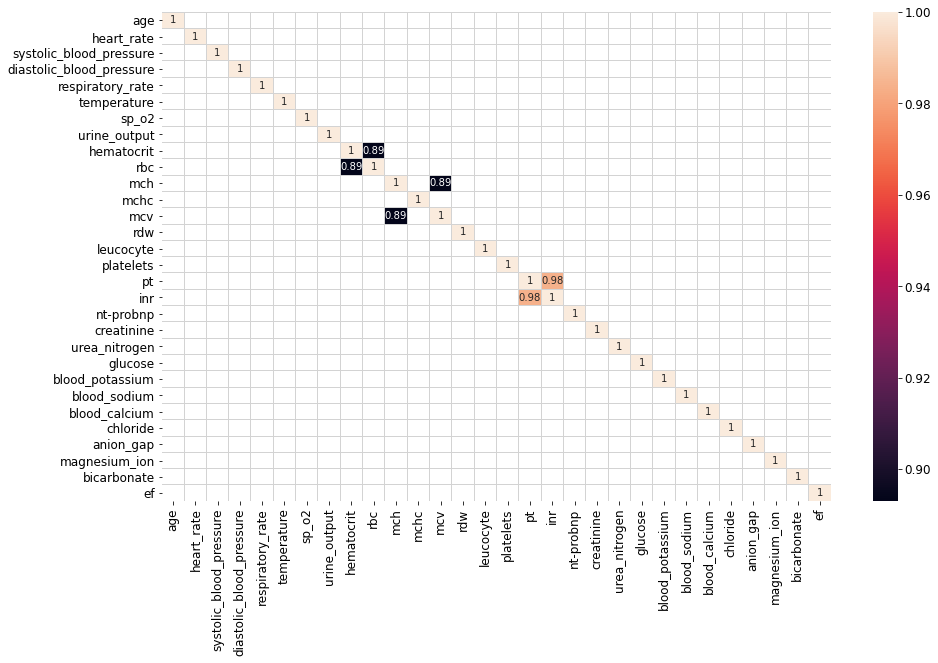

In [4]:
# ---------- show only r-square greater than 0.8 (very strong correlation) ----------

fig, ax = plt.subplots(figsize=(15,9))
sns.heatmap(corr_matrix[corr_matrix>0.8], annot=True, linewidth=0.01, linecolor='lightgrey')
ax.tick_params(labelsize=12)
fig.axes[-1].tick_params(labelsize=12)

### <span style='color:green'>"rbc" and "hematocrit"</span>  
* <span style='color:green'>Strongly correlated.</span>  
* <span style='color:green'>Have no missing values.</span>  

### <span style='color:green'>"mch" and "mcv"</span>  
* <span style='color:green'>Strongly correlated.</span>  
* <span style='color:green'>Have no missing values.</span>  
<br>  
<br>  


In [5]:
df_1[df_1[['pt', 'inr']].isna().any(axis=1)][['inr', 'pt']]

,inr,pt
96,NaN,NaN
151,NaN,NaN
357,NaN,NaN
365,NaN,NaN
525,NaN,NaN
578,NaN,NaN
667,NaN,NaN
698,NaN,NaN
706,NaN,NaN
725,NaN,NaN


### <span style='color:green'>"inr" and "pt"</span>  
* <span style='color:green'>Strongly correlated.</span>  
* <span style='color:green'>Together have missing values not at random (MNAR).</span>  
<br>  
<br>  


<br>  

## <span style='color:blue'>Section 4: Check multicollinearity: Categorical features (Chi-Square)</span>  

In [6]:
#---------- form contingency table ----------

column_names = df_1[['group', 'gendera', 'hypertensive', 'atrialfibrillation', 'chd_with_no_mi', 'diabetes',
                     'deficiencyanemias', 'depression', 'hyperlipemia', 'renal_failure', 'copd']].columns

chi_sq_matrix = pd.DataFrame(df_1[['group', 'gendera', 'hypertensive', 'atrialfibrillation', 'chd_with_no_mi', 'diabetes',
                                   'deficiencyanemias', 'depression', 'hyperlipemia', 'renal_failure', 'copd']],
                             columns=column_names,
                             index=column_names)

In [7]:
# ---------- form correlation matrix ----------

outer_count = 0
inner_count = 0

for i_col in column_names:
    for j_col in column_names:
        cross_tab = pd.crosstab(df_1[i_col], df_1[j_col])
        stat, p, dof, expected = stats.chi2_contingency(cross_tab)
        if expected[expected<5].size == 0:
            chi_sq_matrix.iloc[outer_count, inner_count] = round(p, 3)
        inner_count = inner_count + 1
    outer_count = outer_count + 1
    inner_count = 0

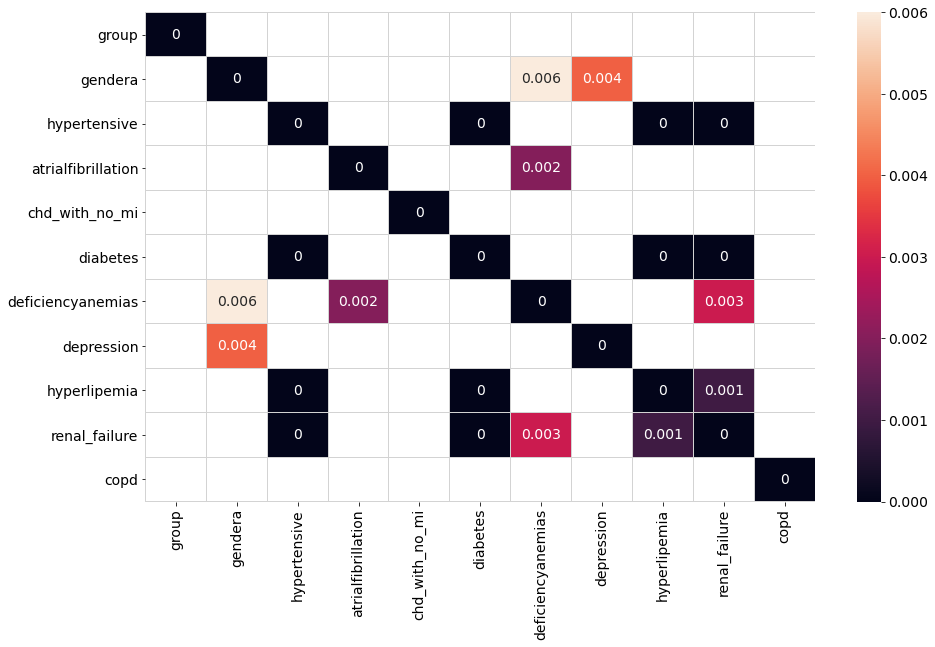

In [8]:
# ---------- show only p value less than 0.01 (very strong correlation) ----------

fig, ax = plt.subplots(figsize=(15,9))
sns.heatmap(chi_sq_matrix[chi_sq_matrix<0.01], annot=True, linewidth=0.01, linecolor='lightgrey', annot_kws={"size":14})
ax.tick_params(labelsize=14)
fig.axes[-1].tick_params(labelsize=14)

### <span style='color:green'>Many features are collinear with each other.</span>  
<br>  
<br>  


<br>  

## <span style='color:blue'>Section 5: Check feasibility of missing value imputation</span>  

### <span style='color:green'>Trial imputation done here.</span>  
### <span style='color:green'>Actual imputation will be done during modelling.</span>  

In [9]:
# ---------- get list of index of incomplete cases and display ----------
# ---------- use same index to check if missing values imputation is successful or not ----------

index_list = df_1[df_1[['urine_output', 'inr', 'pt', 'temperature', 'glucose',
                        'diastolic_blood_pressure', 'systolic_blood_pressure',
                        'sp_o2', 'respiratory_rate', 'heart_rate',
                        'blood_calcium']].isna().any(axis=1)].index

df_1[['urine_output', 'inr', 'pt', 'temperature', 'glucose',
      'diastolic_blood_pressure', 'systolic_blood_pressure',
      'sp_o2', 'respiratory_rate', 'heart_rate',
      'blood_calcium']].iloc[index_list, : ]

,urine_output,inr,pt,temperature,glucose,diastolic_blood_pressure,systolic_blood_pressure,sp_o2,respiratory_rate,heart_rate,blood_calcium
23,NaN,1.471429,16.228571,36.631944,80.000000,62.535714,121.071429,99.300000,17.000000,75.481481,9.287500
31,NaN,1.100000,11.766667,37.067901,94.750000,59.891892,127.945946,99.687500,19.348837,84.029412,9.730000
43,955.0,1.150000,13.066667,36.488889,NaN,45.791667,138.041667,93.916667,18.375000,61.000000,8.075000
51,NaN,1.100000,12.787500,NaN,182.500000,NaN,NaN,NaN,NaN,NaN,8.827273
74,1395.0,1.116667,13.116667,NaN,126.615385,54.843750,113.718750,96.718750,17.656250,73.718750,7.550000
83,821.0,1.300000,14.900000,36.066667,NaN,62.875000,119.541667,93.884615,21.037037,81.925926,9.150000
93,NaN,1.816667,19.150000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.771429
96,2720.0,NaN,NaN,36.166667,138.000000,53.631579,103.578947,97.000000,17.250000,61.250000,8.750000
146,NaN,1.100000,13.050000,36.212963,108.500000,51.190476,129.523809,97.761905,19.809524,73.619048,8.900000
151,1550.0,NaN,NaN,36.817460,210.166667,59.400000,122.800000,94.480000,23.375000,86.360000,9.500000


In [10]:
# ---------- impute using KNN with nearest neighbours set at 5 arbitrarily ----------

knn_impute = KNNImputer(n_neighbors=5)

df_2 = []

df_2 = knn_impute.fit_transform(df_1)

df_2 = pd.DataFrame(df_2, columns=df_1.columns)

# ---------- check if missing values imputation is successful or not ----------

df_2[['urine_output', 'inr', 'pt', 'temperature', 'glucose',
      'diastolic_blood_pressure', 'systolic_blood_pressure',
      'sp_o2', 'respiratory_rate', 'heart_rate',
      'blood_calcium']].iloc[index_list, :]

,urine_output,inr,pt,temperature,glucose,diastolic_blood_pressure,systolic_blood_pressure,sp_o2,respiratory_rate,heart_rate,blood_calcium
23,1656.4,1.471429,16.228571,36.631944,80.000000,62.535714,121.071429,99.300000,17.000000,75.481481,9.287500
31,1263.2,1.100000,11.766667,37.067901,94.750000,59.891892,127.945946,99.687500,19.348837,84.029412,9.730000
43,955.0,1.150000,13.066667,36.488889,205.397143,45.791667,138.041667,93.916667,18.375000,61.000000,8.075000
51,1816.0,1.100000,12.787500,36.598651,182.500000,66.203039,114.362737,96.308636,18.260552,77.303773,8.827273
74,1395.0,1.116667,13.116667,36.858384,126.615385,54.843750,113.718750,96.718750,17.656250,73.718750,7.550000
83,821.0,1.300000,14.900000,36.066667,145.066667,62.875000,119.541667,93.884615,21.037037,81.925926,9.150000
93,2629.0,1.816667,19.150000,36.307566,127.912500,53.968827,118.786369,96.374573,20.453926,77.119294,8.771429
96,2720.0,1.756086,18.269091,36.166667,138.000000,53.631579,103.578947,97.000000,17.250000,61.250000,8.750000
146,1521.8,1.100000,13.050000,36.212963,108.500000,51.190476,129.523809,97.761905,19.809524,73.619048,8.900000
151,1550.0,1.851732,19.497771,36.817460,210.166667,59.400000,122.800000,94.480000,23.375000,86.360000,9.500000


In [11]:
print('Incomplete cases :', df_2.isnull().any(axis=1).sum())

Incomplete cases : 0


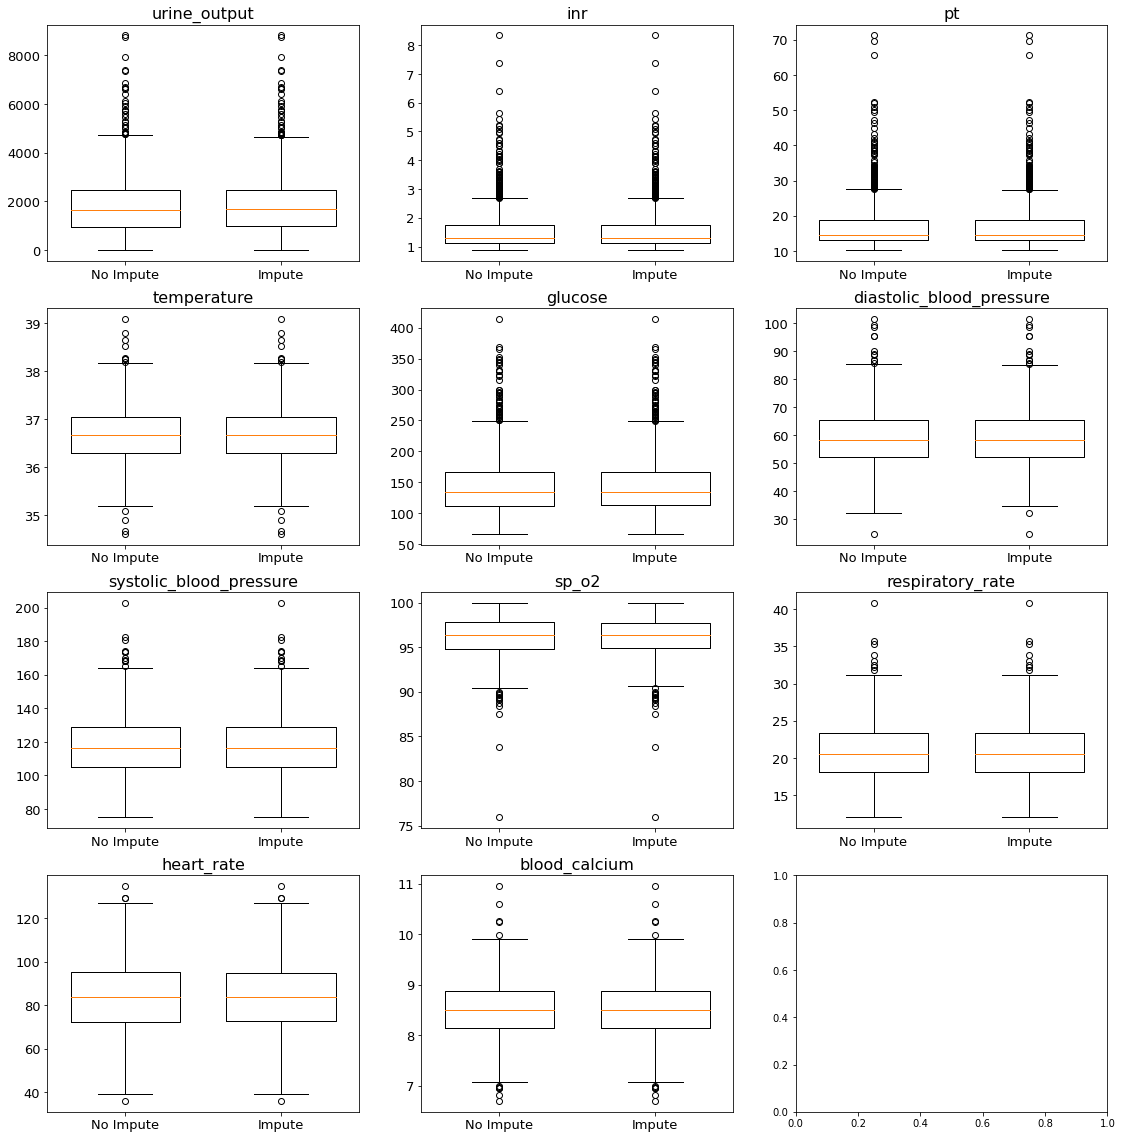

In [12]:
# ---------- visualise missing values imputation success through their probability distributions ----------

fig, ax = plt.subplots(4, 3, figsize=(19, 20))

temp_list = df_1[['urine_output', 'inr', 'pt', 'temperature', 'glucose',
                  'diastolic_blood_pressure', 'systolic_blood_pressure',
                  'sp_o2', 'respiratory_rate', 'heart_rate',
                  'blood_calcium']]
l = 0

for r in range(4):
    for c in range(3):
        try:
            ax[r, c].boxplot([df_1[temp_list.columns[l]][~np.isnan(df_1[temp_list.columns[l]])], df_2[temp_list.columns[l]]], widths=0.7)
            ax[r, c].set_xticklabels(['No Impute', 'Impute'])
            ax[r, c].tick_params(labelsize=13)
            ax[r, c].set_title(temp_list.columns[l], fontdict={'fontsize': 16})
            l = l + 1
        except:
            break


### <span style='color:green'>Diastolic blood pressure</span>  
* <span style='color:green'>Has more outliers after missing values imputation.</span>  
* <span style='color:green'>Probability distribution not significantly affected after missing values imputation.</span>  

### <span style='color:green'>Rest of variables</span>  
* <span style='color:green'>Probability distribution comparable between before and after missing values imputation.</span>  

### <span style='color:green'>Conclusion</span>  
* <span style='color:green'>Feasible to use KNNImputer with n_neighbours=5 for missing value imputation.</span>  
<br>  
<br>  


3 Jan 2022